In [2]:
import numpy as np
from matplotlib import pyplot as plt
from astropy.io import fits
import pysynphot as S
%matplotlib inline

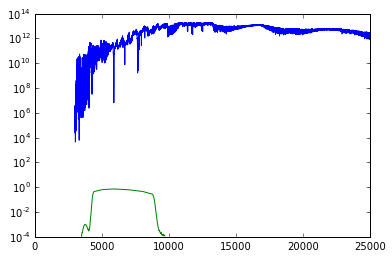

In [31]:
bp = S.FileBandpass('./filters/kep_filter.txt')
spec = S.spectrum.ArraySourceSpectrum(wave=wavelength,flux=flux)
plt.plot(spec.wave,spec.flux)
plt.plot(bp.wave, bp.throughput)
plt.yscale("log")
S.ObsBandpass?

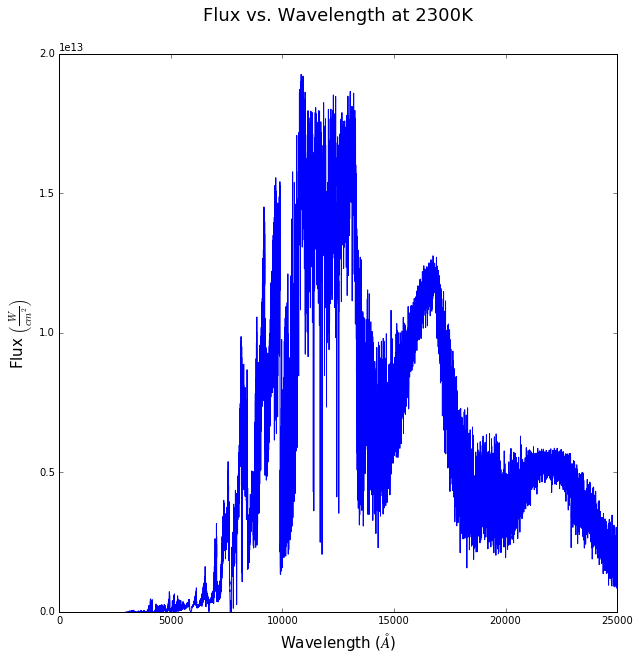

In [34]:
def get_model( temp ):
    '''
    Function opens Phoenix file of specified temperature in 100 Kelvin increments from 2300 to 12000 Kelvin.
    Parameters
    ----------
    temp: str
        Desired temperature in 100K increments from 2300 to 12,000 Kelvin
        
    Returns
    -------
    wavelength: array(pretty sure)
        Associated wavelengths for flux measurements from Phoenix FITS file, in Angstroms
        
    flux: array(also pretty sure)
        Flux measurements from Phoenix FITS file, in erg/s/cm^2
        
    temp: str
        See Parameters
    '''
    model_file = 'PHOENIX-ACES-AGSS-COND-2011_R10000FITS_Z-0.0/lte0' + temp + '-4.50-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits'
    hdulist = fits.open(model_file)
    flux = hdulist[0].data
    wavelength = np.exp(hdulist[0].header[('CRVAL1')]+hdulist[0].header[('CDELT1')]*np.arange(0,212027))
    return wavelength, flux, temp

#User inputs temperature; wavelength, flux and temp are filled with data
wavelength, flux, temp = get_model('2300')

plt.figure(figsize=(10,10))
plt.plot(wavelength,flux)
plt.title('Flux vs. Wavelength at ' + temp + 'K',fontsize=18,y=1.05)
plt.xlabel('Wavelength ($\AA$)', fontsize=15)
plt.ylabel(r'Flux $\left(\frac{W}{cm^2}\right)$', fontsize=15)

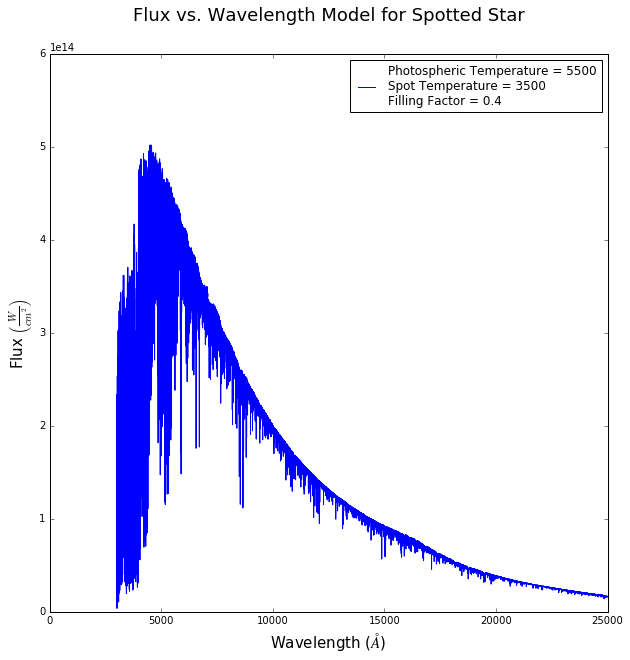

In [35]:
#Function will combine spectra of two temperature models plus filling factor to model starspots
def make_spotmodel( PhTemp, SpTemp, FillFactor ):
    '''
    Funtion models a spotted star through the get_model function by adding two different temperatured spectra
    and combining with a certain filling factor.
    Parameters
    ----------
    PhTemp: str
        Desired photospheric temperature of the star, in 100 Kelvin increments from 2300 to 12,000
    
    SpTemp: str
        Desired temperature of spot, same scale as PhTemp
    
    FillFactor: str
        Fraction of the star's surface covered by spot, decimal from 0 to 1
        
    Returns
    -------
    wavelength: array
        Corresponding wavelengths of spectral data, units of Angstroms
    
    tot_flux: array
        Combined fluxes of the photospheric and spot spectra, units of ergs/s/cm^2
    
    PhTemp, SpTemp, FillFactor: str
        Input values
    '''
    tot_flux = (1-FillFactor)*get_model( PhTemp )[1] + FillFactor*get_model( SpTemp )[1]
    return wavelength, tot_flux, PhTemp, SpTemp, FillFactor

#User inputs parameters
spotmodelwavl, spotmodelfl, PhTemp, SpTemp, FillFactor = make_spotmodel('5500','3500',0.4)

plt.figure(figsize=(10,10))
plt.plot(spotmodelwavl, spotmodelfl)
plt.title('Flux vs. Wavelength Model for Spotted Star',fontsize=18,y=1.05)
plt.xlabel('Wavelength ($\AA$)',fontsize=15)

#How to remove blue line from legend/move it outside plot
plt.legend(['Photospheric Temperature = ' + PhTemp + '\nSpot Temperature = ' + SpTemp +'\nFilling Factor = ' + str(FillFactor)],loc=0)
plt.ylabel(r'Flux $\left(\frac{W}{cm^2}\right)$',fontsize=15)
plt.savefig('spotfig.png')

In [59]:
hdulist.info()

Filename: PHOENIX-ACES-AGSS-COND-2011_R10000FITS_Z-0.0/lte02300-4.50-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU      27   (212027,)    float32   


In [60]:
wavelength.shape
#hdulist[0].shape

(212027,)

In [25]:
hdulist[0].data.shape

(212027,)

In [31]:
hdulist[0].header[('CRVAL1')]

8.006368

In [26]:
hdulist[0].header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    1 / number of data axes                            
NAXIS1  =               212027 / length of data axis 1                          
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
CRVAL1  =             8.006368                                                  
CDELT1  =              1.0E-05                                                  
CTYPE1  = 'AWAV-LOG'                                                            
PHXTEFF =               2300.0 / [K] effective temperature                      
PHXLOGG =                  0.0 / [cm/s^2] log (surface gravity)                 
PHXM_H  =                  0